In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np
import ujson

from collections import Counter, defaultdict
from itertools import islice
from boltons.iterutils import windowed
from tqdm import tqdm_notebook
from glob import glob

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def xy(self, vocab):
        for abstract in self.abstracts():
            yield from abstract.xy(vocab)
            
    def ngram_counts(self, n):
        counts = defaultdict(lambda: 0)
        for ab in self.abstracts():
            for sent in ab.sentences:
                for ngram in sent.ngrams(n):
                    counts[ngram] += 1
        return Counter(counts)
            
    def most_common_ngrams(self, n, depth):
        counts = self.ngram_counts(n)
        return set([k for k, _ in counts.most_common(depth)])

In [4]:
class Abstract:
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
    
    def __init__(self, sentences):
        self.sentences = sentences
    
    def xy(self, vocab):
        for i, sent in enumerate(self.sentences):
            x = sent.features(vocab)
            y = i / (len(self.sentences)-1)
            yield x, y

In [5]:
class Sentence:
    
    def __init__(self, tokens):
        self.tokens = tokens
    
    def ngrams(self, n=1):
        for ng in windowed(self.tokens, n):
            yield '_'.join(ng)
            
    def ngram_counts(self, vocab, maxn=3):
        for n in range(1, maxn+1):
            counts = Counter(self.ngrams(n))
            for k, v in counts.items():
                if k in vocab:
                    yield f'_{k}', v
                    
    def word_count(self):
        return len(self.tokens)
                
    def _features(self, vocab):
        yield from self.ngram_counts(vocab)
        yield 'word_count', self.word_count()
        
    def features(self, vocab):
        return dict(self._features(vocab))

In [6]:
train = Corpus('/Users/dclure/Projects/sent-order/data/train.json/*.json', 100000)

In [8]:
vocab = (
    train.most_common_ngrams(1, 3000) |
    train.most_common_ngrams(2, 2000) |
    train.most_common_ngrams(3, 1000)
)

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

In [9]:
len(vocab)

6000

In [10]:
dv = DictVectorizer()

In [11]:
train_x, train_y = zip(*train.xy(vocab))

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

In [12]:
train_x = dv.fit_transform(train_x)

In [13]:
train_x

<537608x6001 sparse matrix of type '<class 'numpy.float64'>'
	with 16357761 stored elements in Compressed Sparse Row format>

In [14]:
model = LinearRegression()

In [15]:
fit = model.fit(train_x, train_y)

In [16]:
test = Corpus('/Users/dclure/Projects/sent-order/data/test.json/*.json', 50000)

In [17]:
test_x, test_y = zip(*test.xy(vocab))

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

In [18]:
test_x = dv.transform(test_x)

In [19]:
r2_score(test_y, fit.predict(test_x))

0.33128302381815933

In [20]:
names = dv.get_feature_names()

In [21]:
bidx = fit.coef_.argsort()
eidx = np.flip(fit.coef_.argsort(), 0)

In [22]:
for i in bidx[:50]:
    print(fit.coef_[i], names[i])

-0.419277947452 _&_amp
-0.351314286398 _+_/-
-0.2475539718 _Let
-0.234830593641 _-_Mills
-0.230479740918 _Recent
-0.222351126021 _-_called
-0.216474955573 _We_study
-0.210704582877 _in_terms_of
-0.193776045319 _We_consider
-0.192215194466 _We_report
-0.190208856624 _In_addition_to
-0.190008284272 _This_paper
-0.188903352259 _We_investigate
-0.183664188116 _Recently
-0.177633981316 _We_present
-0.177365771278 _Motivated
-0.176900284129 _is_proposed_.
-0.175820240334 _particular_,
-0.169832725847 _pre_-
-0.169648799566 _._Rev
-0.162694828941 _known_that
-0.15823028059 _We_review
-0.152471570615 _We_propose_a
-0.151586908893 _is_one_of
-0.149314036212 _Many
-0.148770270404 _the_context_of
-0.144118182407 _One_of_the
-0.143300999415 _We_introduce
-0.141254070773 _We_prove
-0.138700280882 _co
-0.137735444606 _is_considered
-0.136293307252 _other_hand
-0.135307483438 _article
-0.135046807854 _often
-0.132461651942 _We_construct
-0.13233363436 _of_-
-0.132208356066 _usually
-0.130792828743 _-

In [23]:
for i in eidx[:50]:
    print(fit.coef_[i], names[i])

0.374448305623 _/-
0.362230205123 _Finally
0.257871690949 _&_lt
0.243576199442 _finally
0.238147228365 _In_addition
0.231328414351 _Also
0.226979407745 _Furthermore
0.22265133534 _Moreover
0.209546243285 _Additionally
0.203431510013 _Further
0.198693137605 _Thus
0.197574805242 _conclude
0.196889563981 _pre
0.191334862649 _illustrated
0.191161636027 _in_terms
0.189526429504 _the_other_hand
0.184263134753 _implications
0.180958858592 _in_particular_,
0.179849920841 _&_amp_;
0.179849920841 _amp_;
0.178757269276 _We_conclude
0.176988106989 _Hence
0.172690857076 _illustrate
0.16792231514 _findings
0.15808647954 _Yang_-_Mills
0.156805529797 _comment
0.155800504115 _demonstrates
0.15388064573 _In_particular
0.15189215061 _co_-
0.151664057853 _We_also
0.150725818204 _Therefore
0.14845714624 _In_particular_,
0.146746378346 _suggests
0.146197780376 _The_proposed
0.14598134789 _These_results
0.144464081253 _so_-
0.142011853593 _Our
0.14070435484 _the_proposed
0.138085827555 _examples
0.1379224808

In [24]:
correct = Counter()
total = Counter()

for ab in test.abstracts():
    
    x, _ = zip(*ab.xy(vocab))
    x = dv.transform(x)
    
    order = list(fit.predict(x).argsort().argsort())
    
    if sorted(order) == order:
        correct[len(order)] += 1
        
    total[len(order)] += 1

HBox(children=(IntProgress(value=0, max=50000), HTML(value='')))

In [25]:
for slen in sorted(correct.keys()):
    print(slen, correct[slen] / total[slen])

2 0.8835944299390774
3 0.5513851653261841
4 0.26373507057546147
5 0.09435133457479826
6 0.028445701713028446
7 0.006679594914889032
8 0.0006007810153199159
9 0.0004361098996947231


In [26]:
sum(correct.values()) / sum(total.values())

0.23568

# Sentence length vs. percentage correct

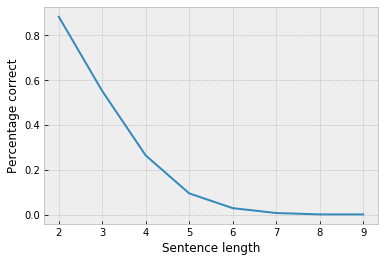

In [27]:
x = sorted(correct.keys())
y = [correct[slen] / total[slen] for slen in x]

plt.xlabel('Sentence length')
plt.ylabel('Percentage correct')
plt.plot(x, y)